In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

from sklearn.pipeline import Pipeline

In [2]:
class MyGaussianNB(BaseEstimator, ClassifierMixin):  
    def fit(self, X, y):                                                   
        N, n = X.shape    
        self.classes, class_counts = np.unique(y, return_counts=True)   
        lenght = len(class_counts)    
        
        self.means = np.zeros((lenght, n), dtype=np.float64)    
        self.st_dvs = np.zeros((lenght, n), dtype=np.float64)   
        self.priors = np.zeros(lenght, dtype=np.float64) 
        
        for idx, c in enumerate(self.classes): 
                X_c = X[y == c]
                self.means[idx, :] = np.nanmean(X_c, axis=0)
                self.st_dvs[idx, :] = np.nanstd(X_c,axis=0)
                self.priors[idx] = X_c.shape[0] / float(N)

    def predict(self, X):
            y_pred = [self.predicts(x) for x in X]
            return np.array(y_pred)

    def predicts(self, x):
        posteriors = []     
        if x is not np.isnan(x).any(axis=0):
            x = np.nan_to_num(x, nan = 0)
            for idx, c in enumerate(self.classes):
                prior = self.priors[idx]
                probs_class = np.prod(self.gaussian_function(idx, x)) 
                probs = probs_class * prior 
                posteriors.append(probs)

            return self.classes[np.argmax(posteriors)]

    def gaussian_function(self, class_idx, x):
        mean = self.means[class_idx]
        std_dv = self.st_dvs[class_idx]
        gaus = np.exp(-((x-mean)**2)/(2*std_dv**2))/((2*std_dv**2 * np.pi) ** .5)
        return gaus 


In [3]:
my_gnb = MyGaussianNB()
gnb = GaussianNB()

In [4]:
penguins_0_2 = pd.read_csv('PenguinsMV0.2.csv', index_col = 0)
penguins_0_2 = penguins_0_2.replace('?',np.NaN)
penguins_0_2.isna().sum()

bill_length       65
bill_depth        69
flipper_length    71
body_mass         63
species            0
dtype: int64

In [5]:
penguins_0_4 = pd.read_csv('PenguinsMV0.4.csv', index_col = 0)
penguins_0_4 = penguins_0_4.replace('?',np.NaN)
penguins_0_4.isna().sum()

bill_length       145
bill_depth        134
flipper_length    121
body_mass         132
species             0
dtype: int64

In [6]:
imp_Pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy = 'mean')),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())])

ite_Pipe = Pipeline(steps =[
    ('imputer', IterativeImputer(missing_values = np.nan)),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())])

# Penguins 20% missing values

In [7]:
y = penguins_0_2.pop('species').values
print(np.unique(y, return_counts=True))
le = LabelEncoder()
y = le.fit_transform(y)
X_raw = penguins_0_2.values
print(np.unique(y))

(array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object), array([146,  68, 119], dtype=int64))
[0 1 2]


In [8]:
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, random_state=2, test_size=0.4)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw) 
X_train.shape, X_test.shape

((199, 4), (134, 4))

In [9]:
fit_penguins = my_gnb.fit(X_train,y_train)
y_pred = my_gnb.predict(X_test)
cfm_My = confusion_matrix(y_test,y_pred)

In [10]:
imp_Pipe.fit(X_train, y_train)
y_pred_SI = imp_Pipe.predict(X_test)
cfm_SI = confusion_matrix(y_test,y_pred_SI)

In [11]:
ite_Pipe.fit(X_train, y_train)
y_pred_ite = ite_Pipe.predict(X_test)
cfm_ite = confusion_matrix(y_test,y_pred_ite)

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


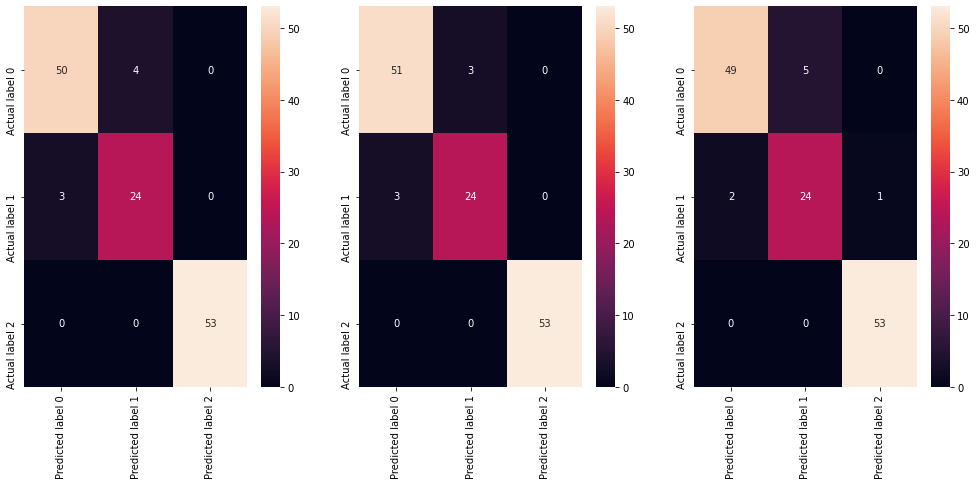

In [12]:
x_axis_labels = ['Predicted label 0','Predicted label 1','Predicted label 2']
y_axis_labels = ['Actual label 0','Actual label 1','Actual label 2'] 
fig = plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
sn.heatmap(cfm_My, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,2)
sn.heatmap(cfm_SI, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,3)
sn.heatmap(cfm_ite, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

In [13]:
X = scaler.fit_transform(X_raw)
acc_arr = cross_val_score(my_gnb, X, y, cv=5)
print('5x CV Accuracy MyGaussianNB: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy MyGaussianNB: 0.92 (+/- 0.04)


In [14]:
acc_arr = cross_val_score(imp_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Simple Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy Simple Imputer: 0.93 (+/- 0.02)


In [15]:
acc_arr = cross_val_score(ite_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Iterative Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


5x CV Accuracy Iterative Imputer: 0.93 (+/- 0.04)


C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
scores = cross_val_score(my_gnb, X, y, cv=5, scoring='f1_micro')
print('10x CV F1 MyGaussianNB: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

10x CV F1 MyGaussianNB: 0.92 (+/- 0.04)


In [17]:
scores = cross_val_score(imp_Pipe, X_raw, y, cv=5, scoring='f1_micro')
print('10x CV F1 Simple Imputer: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

10x CV F1 Simple Imputer: 0.93 (+/- 0.02)


In [18]:
scores = cross_val_score(ite_Pipe, X_raw, y, cv=5, scoring='f1_micro')
print('10x CV F1 Iterative Imputer: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


10x CV F1 Iterative Imputer: 0.93 (+/- 0.04)


C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Penguins 40% missing values

In [19]:
y = penguins_0_4.pop('species').values
y = le.fit_transform(y)
X_raw = penguins_0_4.values

In [20]:
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, random_state=2, test_size=0.4)
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw) 

In [21]:
fit_penguins = my_gnb.fit(X_train,y_train)
y_pred = my_gnb.predict(X_test)
cfm_My = confusion_matrix(y_test,y_pred)

In [22]:
imp_Pipe.fit(X_train, y_train)
y_pred_SI = imp_Pipe.predict(X_test)
cfm_SI = confusion_matrix(y_test,y_pred_SI)

In [23]:
ite_Pipe.fit(X_train, y_train)
y_pred_ite = ite_Pipe.predict(X_test)
cfm_ite = confusion_matrix(y_test,y_pred_ite)

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


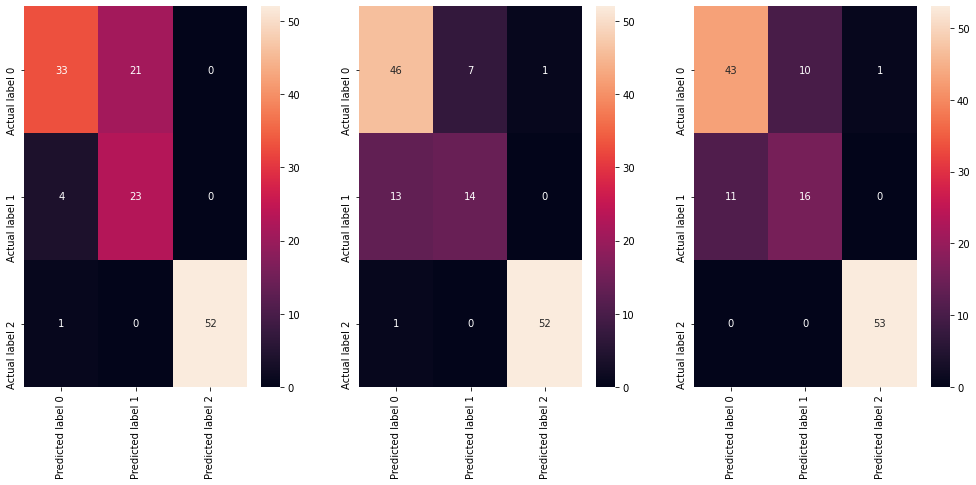

In [24]:
x_axis_labels = ['Predicted label 0','Predicted label 1','Predicted label 2']
y_axis_labels = ['Actual label 0','Actual label 1','Actual label 2'] 
fig = plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
sn.heatmap(cfm_My, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,2)
sn.heatmap(cfm_SI, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,3)
sn.heatmap(cfm_ite, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

In [25]:
X = scaler.fit_transform(X_raw)
acc_arr = cross_val_score(my_gnb, X, y, cv=5)
print('5x CV Accuracy MyGaussianNB: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy MyGaussianNB: 0.76 (+/- 0.18)


In [26]:
acc_arr = cross_val_score(imp_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Simple Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy Simple Imputer: 0.83 (+/- 0.09)


In [27]:
acc_arr = cross_val_score(ite_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Iterative Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


5x CV Accuracy Iterative Imputer: 0.83 (+/- 0.07)


C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
scores = cross_val_score(my_gnb, X, y, cv=5, scoring='f1_micro')
print('10x CV F1 MyGaussianNB: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

10x CV F1 MyGaussianNB: 0.76 (+/- 0.18)


In [29]:
scores = cross_val_score(imp_Pipe, X_raw, y, cv=5, scoring='f1_micro')
print('5x CV F1 Simple Imputer: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

5x CV F1 Simple Imputer: 0.83 (+/- 0.09)


In [30]:
scores = cross_val_score(ite_Pipe, X_raw, y, cv=5, scoring='f1_micro')
print('5x CV F1 Iterative Imputer: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


5x CV F1 Iterative Imputer: 0.83 (+/- 0.07)


C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Diabetes 30% missing

In [31]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,preg,plas,pres,skin,insu,mass,pedi,age,neg_pos
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [32]:
y = diabetes.pop('neg_pos').values
diabetes = diabetes.mask(np.random.random(diabetes.shape) < .3)
diabetes.head(25)

,preg,plas,pres,skin,insu,mass,pedi,age
0,6.0,148.0,72.0,35.0,0.0,NaN,NaN,50.0
1,NaN,NaN,66.0,NaN,0.0,26.6,NaN,31.0
2,NaN,NaN,NaN,0.0,0.0,NaN,NaN,32.0
3,NaN,89.0,66.0,23.0,94.0,NaN,0.167,21.0
4,0.0,137.0,NaN,NaN,168.0,43.1,2.288,33.0
5,5.0,116.0,74.0,0.0,NaN,25.6,0.201,30.0
6,3.0,78.0,50.0,NaN,88.0,31.0,NaN,NaN
7,10.0,NaN,0.0,0.0,0.0,NaN,0.134,NaN
8,2.0,197.0,NaN,45.0,543.0,NaN,0.158,53.0
9,8.0,NaN,96.0,NaN,0.0,NaN,0.232,54.0


In [33]:
diabetes.isna().sum()

preg    216
plas    214
pres    217
skin    210
insu    229
mass    245
pedi    250
age     245
dtype: int64

In [34]:
y = le.fit_transform(y)
X_raw = diabetes.values

In [35]:
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, random_state=2, test_size=0.4)
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw) 
X_train.shape, X_test.shape

((460, 8), (308, 8))

In [36]:
fit_diabetes = my_gnb.fit(X_train,y_train)
y_pred = my_gnb.predict(X_test)
cfm_My = confusion_matrix(y_test,y_pred)

In [37]:
imp_Pipe.fit(X_train, y_train)
y_pred_SI = imp_Pipe.predict(X_test)
cfm_SI = confusion_matrix(y_test,y_pred_SI)

In [38]:
ite_Pipe.fit(X_train, y_train)
y_pred_ite = ite_Pipe.predict(X_test)
cfm_ite = confusion_matrix(y_test,y_pred_ite)

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


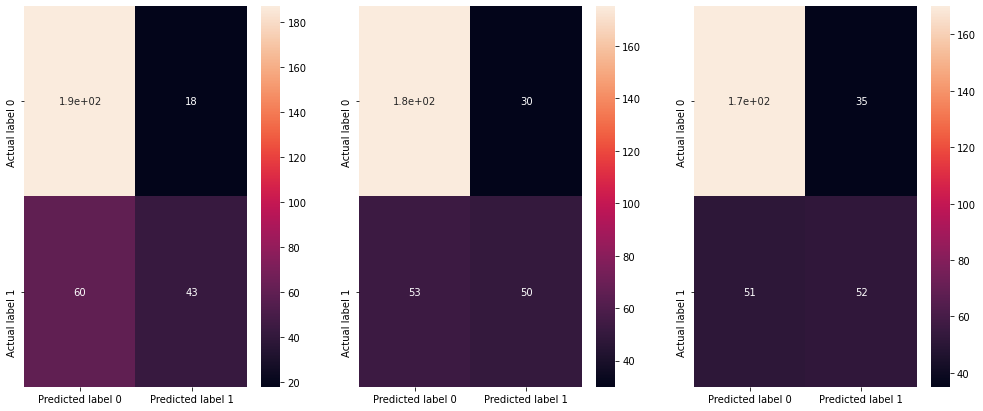

In [39]:
x_axis_labels = ['Predicted label 0','Predicted label 1']
y_axis_labels = ['Actual label 0','Actual label 1'] 
fig = plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
sn.heatmap(cfm_My, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,2)
sn.heatmap(cfm_SI, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.subplot(1,3,3)
sn.heatmap(cfm_ite, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

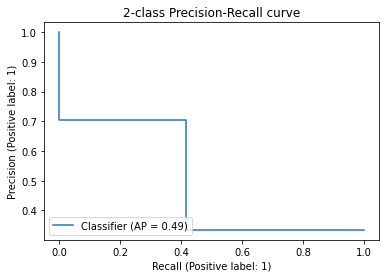

In [40]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
_ = display.ax_.set_title("2-class Precision-Recall curve")

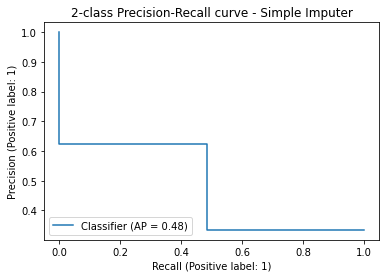

In [41]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_SI)
_ = display.ax_.set_title("2-class Precision-Recall curve - Simple Imputer")

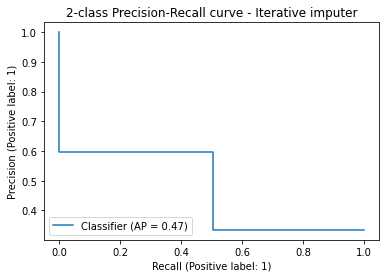

In [42]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_ite)
_ = display.ax_.set_title("2-class Precision-Recall curve - Iterative imputer")

In [43]:
X = scaler.fit_transform(X_raw)
acc_arr = cross_val_score(my_gnb, X, y, cv=5)
print('5x CV Accuracy MyGaussianNB: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy MyGaussianNB: 0.74 (+/- 0.06)


In [44]:
acc_arr = cross_val_score(imp_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Simple Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

5x CV Accuracy Simple Imputer: 0.74 (+/- 0.05)


In [45]:
acc_arr = cross_val_score(ite_Pipe, X_raw, y, cv=5)
print('5x CV Accuracy Iterative Imputer: %0.2f (+/- %0.2f)' % (acc_arr.mean(), acc_arr.std() * 2))

C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


5x CV Accuracy Iterative Imputer: 0.74 (+/- 0.05)


C:\Users\anton\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Summary report

### Design desicions 

In order to have my GNB code handle NaNs in the fit method I changed the code so that only non-NaN array elements goes into the calculation of mean and standard deviations. This is done by the **np.nanmean** and **np.nanstd** functions. Further on, to have the predict method operationable despite NaNs in test samples I opted to use an identity test that checks if the individual test sample is a sample that holds NaN. The code will then replace NaNs in the test sample with 0. More specifically, to my helper method *def predicts* which the predict method calls, I added this function: **if x is not np.isnan(x).any(axis=0):** and then: **x = np.nan_to_num(x, nan = 0)**. The reason I opted to do it this way is because I am using a StandardScaler() to scale the data which makes the mean of the distribution 0. So when we are imputing 0 instead of NaN, I believe we are essentially doing a mean imputation for whatever feature the NaN was positioned in. 

### Evaluation

In the dataset with 20% missing values our classifier performs nearly as well as library implmentation. Accuracy and F1 scores are high and similar across the board. Overall, all implementations works very good but the pipeline that utilizes mulitvariate imputation has marginally better cross-validated predictive performance. 

Unsuprisingly, the dataset with 40% missing values yields worse results. The predicitve performance is worse across all implementations. However, the performance is still moderately good for all implementations. Our classifier does not perform as well as the pipelines. Considering that my GNB code does not result in the same estimates as the simple imputer pipeline, my working hypothesis regarding design descisions I made to my predict function seems disconfirmed. It looks like I am not doing mean imputation by replacing NaNs with 0s after all. Or at least that the GNB code does not behave in the same way as the simple imputer pipeline. The confusion matrix indicate that our classifier is biased towards the minority class. Overall however, I think my GNB code works reasonably well. The pipeline with best performance is the one utilizing mulitvariate imputation.

Seeing the results from the 40% missing dataset, I thought it would be interesting to see how the classifier would react to for instance diabetes data that holds NaNs in features. In this case we know that the minority class is more important. If our classifier would behave similarly as here in that situation, it might be beneficial to use it comparatively to the pipelines given that we want to minimize the false negative rate in that scenario. 

I decided to test this by importing the diabetes data and adding 30% missing values to each feature. Cross-validated accuracy scores were almost the same for each implementation. However, as indicated by the confusion matrices and precision-recall curves the GNB code did not retain a particular bias towards the minority class which I believe invalidate its comparative utility relative to the other implementations in this classification task as well.